In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from scipy.optimize import curve_fit
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns
from scipy import stats
from scipy import interpolate
from sklearn.metrics import r2_score

In [85]:
#high = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_44_52_1_2021-07-16')
#med = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_47_24_1_2021-07-16')
#low = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_83_22_1_2021-07-16')
folders = [r'D:\runs\Run_0_100_12_1_2021-07-16',r'D:\runs\Run_0_100_8_1_2021-07-16',r'D:\runs\Run_0_100_19_1_2021-07-16']
types = [Path(x) / 'Results/ntypes.csv' for x in folders]
biomass = [Path(x) / 'Results/biomass.csv' for x in folders]
Cons = [Path(x) / 'Results/avg_concentration.csv' for x in folders]
expPath = r'../experimental-data/ecw-growth-R2.xlsx'
experimentalData = pd.read_excel(expPath)
labels = ['20 g/L','10 g/L','5 g/L','2 g/L']


In [86]:
experimentalData

,Time,OD600,Initial Sucrose,Replicate
0,0,0.010,20,1
1,1,0.018,20,1
2,2,0.051,20,1
3,3,0.133,20,1
4,4,0.379,20,1
...,...,...,...,...
175,10,3.590,2,3
176,11,3.790,2,3
177,13,3.990,2,3
178,19,4.007,2,3


In [87]:
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
dens = 1e9
Volume = 1e-4*1e-4*1e-5 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
#CellNum2OD = Volume*cellsperOD*mlm3
CellNum2OD = Volume/1e-9
Biomass2OD = 1e12
tStep2Days = 10/3600/24
sucs = np.linspace(0,1,6)
pctC = 0.5
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
def cells2OD(x):
    return (x+4e7)/1e9/(Volume*mlm3)
    
def func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))
def logistic_regression(x,y):
    popt, pcov = curve_fit(func, 
                        x, 
                        y,          
                        p0 = [0.80309017, 0.24164053, 0.01670965],        
                        maxfev=10000
                        )
    return popt




In [88]:
1/(Volume*mlm3)*8e-8

0.7999999999999998

In [102]:
temp = experimentalData.groupby(['Initial Sucrose','Replicate']).apply(lambda x: logistic_regression(x['Time'],x['OD600']))

In [135]:
experimentalFits = pd.DataFrame(columns=['Initial Sucrose','Replicate','Max','mu','t0'])
for s in temp.reset_index().iterrows():
    experimentalFits=experimentalFits.append(pd.DataFrame([[s[1]['Initial Sucrose'],s[1]['Replicate'],s[1][0][0],s[1][0][1],s[1][0][2]]],columns=['Initial Sucrose','Replicate','Max','mu','t0']),ignore_index=True)

In [148]:
experimentalFits.groupby(['Initial Sucrose']).mean()

,Max,mu,t0
Initial Sucrose,,,
2,4.057535,0.669260,0.039871
5,7.479576,0.874520,0.014437
10,10.951256,0.983898,0.005683
20,11.939218,0.905239,0.008513


In [58]:
for path in types:
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.Time = df.Time/60/60*10 #convert timesteps (10s) to days
    df['OD'] = df.iloc[:,1]*CellNum2OD
df

,Time,Cells,OD
0,0.000000,100,0.0100
1,0.277778,100,0.0100
2,0.555556,105,0.0105
3,0.833333,113,0.0113
4,1.111111,122,0.0122
...,...,...,...
346,96.111111,2161,0.2161
347,96.388889,2161,0.2161
348,96.666667,2161,0.2161
349,96.944444,2161,0.2161


In [66]:
cells2OD(100)

400000.9999999999

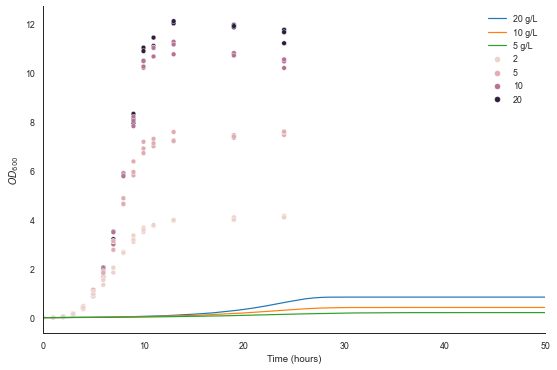

In [29]:
sns.set_context('paper')
sns.set_style('white')
mus =list()
f, ax = plt.subplots(figsize=(9,6))
for path,label in zip(types,labels):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.index = df.Time/60/60*10 #convert timesteps (10s) to days
    df.index.name='Hours'
    df['OD'] = df.iloc[:,1]*CellNum2OD
    ax.plot(df.OD,label=label)
    popt, pcov = curve_fit(func,df.index.values,df.OD,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1])
    #ax.plot(df.index.values,func(df.index.values,*popt),ls='--')

ax.legend().remove()
ax.set_xlim([0,50])
#ax.plot(Control.Time,Control.OD600,label='Experimental',c='k')
#popt, pcov = curve_fit(func,Control.Time,Control.OD600,p0=[0.80309017, 0.24164053, 0.01670965])
#ax.plot(Control.Time,func(Control.Time,*popt),ls='--',c='grey')
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=Control,ax=ax)
ax.set_xlabel('Time (hours)')
ax.set_ylabel(r'$OD_{600}$')
ax.legend(frameon=False)

sns.despine()

In [6]:
growth = pd.DataFrame([mus,[20,10,5]]).T
growth.columns=['mu','Sucrose']
growth

,mu,Sucrose
0,0.320248,20.0
1,0.255373,10.0
2,0.183655,5.0


In [24]:
df

,Time,Cells,OD
Hours,,,
0.000000,0,100,1000000.0
0.277778,100,100,1000000.0
0.555556,200,105,1050000.0
0.833333,300,113,1130000.0
1.111111,400,122,1220000.0
...,...,...,...
96.111111,34600,2161,21610000.0
96.388889,34700,2161,21610000.0
96.666667,34800,2161,21610000.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


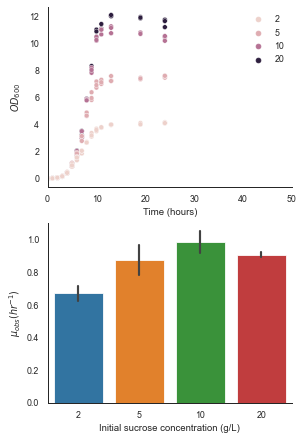

In [145]:
#f,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,15))
colors = ['#e34a33','#fdbb84','#fee8c8']
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')

ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0])
""" mus =list()
for i,(path,label) in enumerate(zip(types,labels)):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df['Hours'] = df.Time/60/60*10 #convert timesteps (10s) to days
    df['OD600'] = df['Cells']*CellNum2OD
    #ax1.plot(df.OD,label=label,c=colors[i])
    sns.lineplot(x='Hours',y='OD600',data=df)
    popt, pcov = curve_fit(func,df.index.values,df.OD600,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1]) """


ax1.legend().remove()
ax1.set_xlim([0,50])

sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=experimentalData,ax=ax1)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel(r'$OD_{600}$')
ax1.legend(frameon=False)


sns.barplot(x='Initial Sucrose',y='mu',data=experimentalFits,ax=ax2,ci='sd')
ax2.set_xlabel('Initial sucrose concentration (g/L)')
ax2.set_ylabel(r'$\mu_{obs} (hr^{-1})$ ')

sns.despine()


fig.align_ylabels()
#fig.savefig('validationEC.png',dpi=600)
#f.tight_layout()



In [50]:
data = utils.get_data(r'D:\runs\Run_0_100_12_1_2021-07-16')

In [51]:
data.avg_con

,O2,Sucrose,CO2
Hours,,,
0.000000,0.281250,5.842828e+01,0.679391
0.277778,0.281249,5.839068e+01,0.679392
0.555556,0.281249,5.835118e+01,0.679392
0.833333,0.281249,5.830973e+01,0.679392
1.111111,0.281249,5.826620e+01,0.679392
...,...,...,...
96.111111,0.281249,1.955348e-36,0.679392
96.388889,0.281249,1.455464e-36,0.679392
96.666667,0.281249,1.083694e-36,0.679392


In [52]:
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume/1e-9
df2 = pd.concat([data.ntypes.ecw*CellNum2OD,data.ntypes.step/60/60*data.timestep],axis=1)
df2.columns=['OD600','Hours']
SucroseMW = 342.3

In [53]:
df.groupby('S0').mean()['mu']

S0
0     0.001433
1     0.002010
2     0.163883
3     0.207408
4     0.216891
5     0.213029
10    0.264609
12    0.255564
14    0.301827
16    0.294783
18    0.277585
20    0.299615
Name: mu, dtype: float64

In [54]:
growthRates = {1 : 0.002,2:.163,5:.21,10:.265,20:.2996}

In [55]:
data.avg_con.Sucrose[0]*SucroseMW/1e3

20.0

[0.85153994 0.32024766 0.00115569]


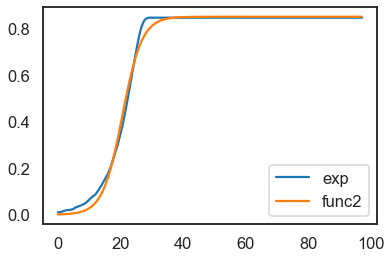

In [56]:
def grow(x,a,k,b):
    return a/(1+b*np.exp(x*k))

popt2, pcov2 = curve_fit(func,df2.Hours, df2.OD600)
print(popt2)
xrange= np.arange(0,df2.Hours.max(),1)

plt.plot(df2.Hours,df2.OD600,label='exp')
plt.plot(xrange,func(xrange,*popt2),label='func2')
plt.legend()